# tf_DCGAN_2Dchemim
-------
### Tensorflow Deep convolutional GAN using 2D images of chemical structures

## Setup
### Packages

In [1]:
# import needed packages
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pathlib

from IPython import get_ipython
from IPython import display

In [2]:
import tensorflow as tf
import tensorboard

print("Tensorflow version:"+str(tf.__version__)+"\nTensorboard version:"+str(tensorboard.__version__))

Tensorflow version:2.3.0
Tensorboard version:2.3.0


In [3]:
%load_ext tensorboard
%tensorboard --logdir logs
from tensorboard import notebook
notebook.list()
#notebook.display(port=6006, height=1000) 

Reusing TensorBoard on port 6006 (pid 13465), started 0:41:59 ago. (Use '!kill 13465' to kill it.)

## Network parameters

In [4]:
# data source
data_dir = "/home/other/northj/datasets/dataset_2020_09_07_chemimages/expt/"

data_dir = pathlib.Path(data_dir)       # fix using pathlib

# dataloader
img_height = 128
img_width = 128
batch_size = 64

BUFFER_SIZE = 60000
BATCH_SIZE = batch_size

# training
EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 16

In [5]:
# count the number of images, specifically those that are .png files
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

535383


## Create a dataset
------
### Use a 20% validation split from your dataset

In [6]:
# May have to reshape... but do so BEFORE batching!
#train_ds = train_ds.reshape(train_ds.shape[0], 128, 128, 1).astype('float32')

In [7]:
# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode=None,     # crucial to be able to ditch the labels!!!
  batch_size=batch_size)

# Load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  label_mode = None,    # crucial to be able to ditch the labels!!!
  batch_size=batch_size)

Found 535383 files belonging to 1 classes.
Using 428307 files for training.
Found 535383 files belonging to 1 classes.
Using 107076 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)



['drw_attempt1']


In [9]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

### Visualize the input data

Here are the first 9 images from the training dataset:

(64, 128, 128, 3)


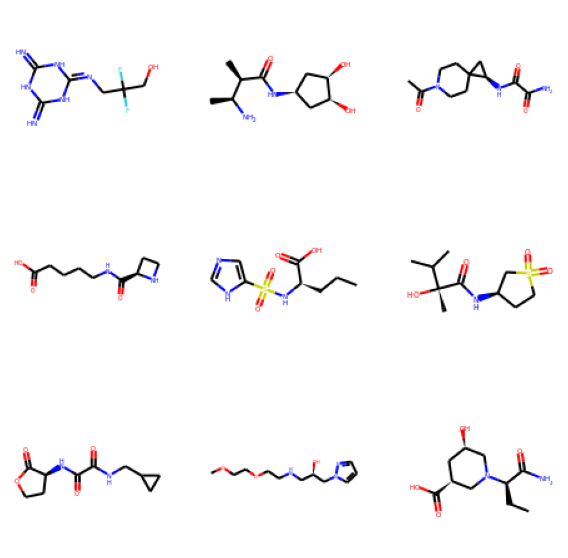

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
#for images, labels in train_ds.take(1):
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")
#for image_batch, labels_batch in train_ds:
for image_batch in train_ds:
    print(image_batch.shape)
    #print(labels_batch.shape)
    break

In [11]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)    # scale to 0-1

In [12]:
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_ds = train_ds.map(lambda x: (normalization_layer(x)))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image)) 
train_ds = normalized_ds

### Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)      # cache to prevent from needing to re-setup each time
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# Batch and shuffle the data -- only necessary when rank >=1 / already done 
#train_ds = tf.data.Dataset.from_tensor_slices(train_ds).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create the network model
--------
## Generator

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 64)))
    assert model.output_shape == (None, 16, 16, 64) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 16)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 4)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)        # ENSURE img size and channels are correct!!!

    return model

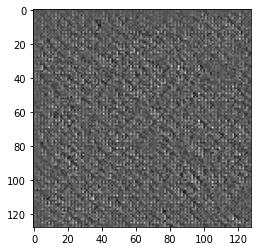

In [16]:
# Use the generator to create an image.

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [17]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 16)        25600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0

## Discriminator

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(3, (5, 5), strides=(1, 1), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))      # model's decision about whether an image is real 
                                    # or fake, e.g. 1=real, 0=fake

    return model

In [19]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00019914]], shape=(1, 1), dtype=float32)


In [20]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 3)       228       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 128, 3)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)       

## Loss function and optimizers (universal)

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizers

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define training loop

In [26]:
# We will reuse this seed overtime (so it's easier to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                            epochs,
                            seed)

# Testing the model

In [29]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [30]:
print(train_ds)

<PrefetchDataset shapes: (None, 128, 128, 3), types: tf.float32>


In [31]:
train(train_ds, EPOCHS)

KeyboardInterrupt: 

In [ ]:
# Restore the latest checkpoint.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Show results

## Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

## Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


# %%
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)